In [1]:
device = 'cpu'

In [2]:
# import crossentropy
import torch.nn as nn
criterion = nn.CrossEntropyLoss()

In [3]:
from torchvision import transforms
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4471], std=[0.2023, 0.1994, 0.2010]) # CIFAR-10 stats
])
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4471], std=[0.2023, 0.1994, 0.2010]) # CIFAR-10 stats
])

In [4]:
# load cifar10 for torch
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader


train_dataset = CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_dataset = CIFAR10(root='./data', train=False, download=True, transform=transform_test)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [5]:
# load resnet18 for torch with CIfar10 weights
import torch.nn as nn
from resnet import resnet18
import torch.ao.quantization as quantization
import torch 

# Load the pretrained model
model = resnet18()
model.load_state_dict(torch.load("resnet18.pt"))
...

C:\Users\ahmad\AppData\Local\Temp\ipykernel_2712\3941452769.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("resnet18.pt"))


Ellipsis

In [6]:
def test(model, dataloader, device):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in dataloader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            
            test_loss += criterion(output, target).item()  # sum up batch loss

            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(dataloader.dataset)

    return test_loss, 100. * correct / len(dataloader.dataset)

In [7]:
import time
import torch

def log_model(model,verbose = 1):
    model = model.to('cpu')
    model.eval()
    input_tensor = torch.randn(1, 3, 32, 32)

    start_time = time.time()
    with torch.no_grad():
        model.forward(input_tensor)
    end_time = time.time()
    inference_time = (end_time - start_time)
    # Count total parameters
    total_params = sum(p.numel() for p in model.parameters())

    # Compute size in MB (assuming float32: 4 bytes per parameter)
    model_size_mb = total_params * 4 / (1024 ** 2)
    accuracy = test(model, test_dataloader, device)[1]
    if verbose:
        print("Inference time:", f"{inference_time}", "ms")
        print(f'Model size = {model_size_mb:.2f} MB')
        print(f"Model accuracy: {accuracy:.2f}")
        return
        
    return total_params, model_size_mb, inference_time, accuracy 

In [8]:
log_model(model)

Inference time: 0.03723931312561035 ms
Model size = 42.63 MB
Model accuracy: 92.57


In [9]:

# using distillation
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = self.relu(out)
        return out

    
class ResNet8(nn.Module):
    def __init__(self, num_classes=10):
        super(ResNet8, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        
        self.layer1 = ResidualBlock(16, 16, stride=1)  # 32x32 → 32x32
        self.layer2 = ResidualBlock(16, 32, stride=2)  # 32x32 → 16x16
        self.layer3 = ResidualBlock(32, 64, stride=2)  # 16x16 → 8x8
        self.relu = nn.ReLU()
        self.fc = nn.Linear(64 * 8 * 8, num_classes)

    def forward(self, x):
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.view(out.size(0), -1)
        return self.fc(out)


In [10]:
model_student = ResNet8(num_classes=10)
model_student = model_student.to('cuda')

In [11]:
from torch.nn import functional as F
def distillation_loss(student_logits, teacher_logits, labels, T=4.0, alpha=0.7):
    """
    student_logits: (batch_size, num_classes)
    teacher_logits: (batch_size, num_classes)
    labels:         (batch_size) ground truth class indices
    T: Temperature
    alpha: weight for distillation vs. real labels
    """
    # 1) Distillation part (Kullback-Leibler divergence between softened probabilities)
    #    Use log_softmax for student, softmax for teacher or vice versa.
    #    In PyTorch, KLDiv expects log-probabilities for input and probabilities for target
    distill_loss = nn.KLDivLoss(reduction='batchmean')(
        input=F.log_softmax(student_logits / T, dim=1),
        target=F.softmax(teacher_logits / T, dim=1)
    ) * (T * T)

    # 2) Standard cross-entropy loss on true labels
    ce_loss = F.cross_entropy(student_logits, labels)

    # Weighted sum
    return alpha * distill_loss + (1 - alpha) * ce_loss

In [12]:
# Initializing criterion, optimizer
from torch import optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_student.parameters(), lr=0.001)

def train_distillation(model_teacher,model_student, dataloader, device, ):
    total_loss = 0
    for batch_idx, (data, target) in enumerate(dataloader):
        model.train()
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        student_outputs = model_student(data)
        teacher_outputs = model_teacher(data)
        loss = distillation_loss(student_outputs, teacher_outputs, target,)
        total_loss += loss.item()
        
        loss.backward()
        optimizer.step()
        
        if batch_idx % 10 == 0:
            print(f"\rBatch: { batch_idx}/{len(dataloader)}, Loss: {total_loss/(batch_idx+1):.4f}                           ", end = '')
    train_loss, train_acc = test_distillation(model_teacher,model_student, dataloader, device)
    return train_loss, train_acc

def test_distillation(model_teacher,model_student, dataloader, device):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in dataloader:
            data, target = data.to(device), target.to(device)
            student_outputs = model_student(data)
            teacher_outputs = model_teacher(data)
            test_loss += distillation_loss(student_outputs, teacher_outputs, target,)  # sum up batch loss

            pred = student_outputs.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            teacher_labels = teacher_outputs.argmax(dim=1)
            
            correct += pred.eq(teacher_labels.view_as(pred)).sum().item()

    test_loss /= len(dataloader.dataset)

    return test_loss, 100. * correct / len(dataloader.dataset)


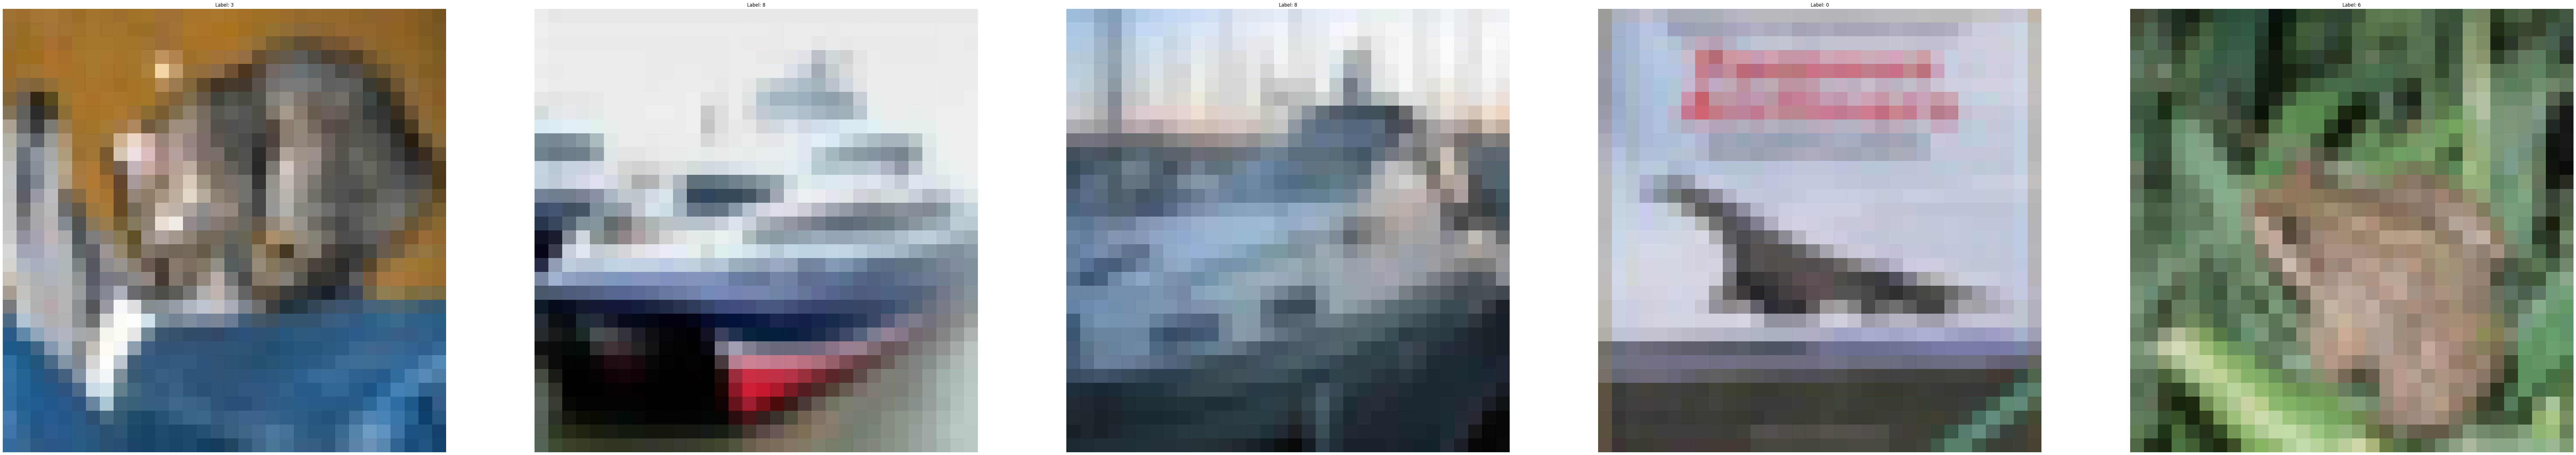

In [13]:
#visualize a sample of the test set
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 5, figsize=(120,30))
for i in range(5):
    img, label = test_dataset.data[i], test_dataset.targets[i]
    axs[i].imshow(img)
    axs[i].set_title(f"Label: {label}")
    axs[i].axis('off')
plt.show()


In [24]:
best_loss = float('inf')  # Use -float('inf') for accuracy tracking

def save_best(model, val_loss, best_val_loss):
    if val_loss < best_val_loss:  # Replace with val_acc > best_val_acc if tracking accuracy
        best_val_loss = val_loss
        torch.save(model.state_dict(), "best_model.pth")
        print("Best model saved!", end = ' ')
    return best_val_loss
        

In [25]:
model_teacher = model.to('cuda')

# Training 
training_loss = []
training_accuracy = []

for epoch in range(60):
    print("Epoch", epoch+1)
    train_loss, train_acc = train_distillation(model_teacher, model_student, train_dataloader, 'cuda',  )
    test_loss, test_acc = test_distillation(model_teacher,model_student ,test_dataloader, 'cuda',)
    best_loss = save_best(model_student, test_loss.item(), best_loss)
    print(f"\nTrain Loss = {train_loss:.4f}, Train Accuracy = {train_acc:.2f}")
    training_loss.append(test_loss)
    training_accuracy.append(test_acc)
    print(f"Test Loss = {test_loss:.4f}, Test Accuracy = {test_acc:.2f}")

Epoch 1
Batch: 1560/1563, Loss: 1.6135                           Best model saved! 
Train Loss = 0.0518, Train Accuracy = 67.58
Test Loss = 0.0455, Test Accuracy = 69.56
Epoch 2
Batch: 1560/1563, Loss: 1.4287                           Best model saved! 
Train Loss = 0.0491, Train Accuracy = 70.83
Test Loss = 0.0437, Test Accuracy = 71.17
Epoch 3
Batch: 1560/1563, Loss: 1.3129                           Best model saved! 
Train Loss = 0.0462, Train Accuracy = 73.55
Test Loss = 0.0422, Test Accuracy = 73.02
Epoch 4
Batch: 1560/1563, Loss: 1.2380                           Best model saved! 
Train Loss = 0.0403, Train Accuracy = 76.25
Test Loss = 0.0366, Test Accuracy = 76.31
Epoch 5
Batch: 1560/1563, Loss: 1.1808                           
Train Loss = 0.0409, Train Accuracy = 76.99
Test Loss = 0.0387, Test Accuracy = 75.67
Epoch 6
Batch: 1560/1563, Loss: 1.1372                           Best model saved! 
Train Loss = 0.0390, Train Accuracy = 77.89
Test Loss = 0.0365, Test Accuracy = 76.9

KeyboardInterrupt: 

In [27]:
model_student.load_state_dict(torch.load("best_model.pth"))

C:\Users\ahmad\AppData\Local\Temp\ipykernel_2712\4240523294.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_student.load_state_dict(torch.load("best_model.pth"))


<All keys matched successfully>

In [28]:
log_model(model_student)

Inference time: 0.003545999526977539 ms
Model size = 0.45 MB
Model accuracy: 83.80


In [32]:
for i in range(len(training_loss)):
    training_loss[i] = training_loss[i].item()

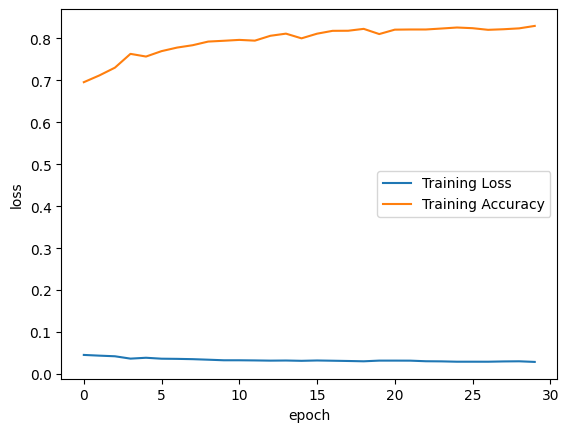

In [35]:
# plot training loss and accuracy
import matplotlib.pyplot as plt
import numpy as np
plt.plot(training_loss, label = 'Training Loss')
plt.plot(np.array(training_accuracy)/100, label = 'Training Accuracy')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()

In [36]:
import copy

quantized_model = copy.deepcopy(model_student)

# Quantize the model
quantized_model = torch.quantization.quantize_dynamic(
    quantized_model,
    {nn.Linear,nn.Conv2d, nn.ReLU}, 
    dtype=torch.float16).to("cpu")

In [37]:
log_model(quantized_model)

Inference time: 0.002549886703491211 ms
Model size = 0.30 MB
Model accuracy: 83.80


In [38]:
model_student.eval()
# Fuse layers
fuse_list = [
    ["conv1", "bn1", "relu"],  # First conv layer fusion

    ["layer1.conv1", "layer1.bn1", "layer1.relu"],  
    ["layer1.conv2", "layer1.bn2"],  

    ["layer2.conv1", "layer2.bn1", "layer2.relu"],  
    ["layer2.conv2", "layer2.bn2"],  
    ["layer2.shortcut.0", "layer2.shortcut.1"],  # Fuse shortcut path

    ["layer3.conv1", "layer3.bn1", "layer3.relu"],  
    ["layer3.conv2", "layer3.bn2"],  
    ["layer3.shortcut.0", "layer3.shortcut.1"],  # Fuse shortcut path
]

In [39]:
# 1. Create a copy of the model for quantization
model_static_quantize = copy.deepcopy(quantized_model)
model_static_quantize.to(device)
model_static_quantize.eval()
# Fuse the modules in place.
# Note: fuse_modules works recursively on submodules.
torch.quantization.fuse_modules(model_static_quantize, fuse_list, inplace=True)
model_static_quantize.qconfig = quantization.get_default_qconfig("fbgemm")
model_static_quantize = quantization.prepare(model_static_quantize)

dummy_input = torch.randn(1, 3, 32, 32)
model_static_quantize(dummy_input)  # This helps the model learn quantization ranges

static_quantized_model = quantization.convert(model_static_quantize)

d:\program_files\anaconda3\envs\torch_gpu\Lib\site-packages\torch\ao\quantization\observer.py:229: UserWarning: Please use quant_min and quant_max to specify the range for observers.                     reduce_range will be deprecated in a future release of PyTorch.
  warnings.warn(


In [40]:
dynamic_fused_trail = copy.deepcopy(static_quantized_model)
quantized_dynamic_fused_trail = torch.quantization.quantize_dynamic(
    dynamic_fused_trail, {nn.Linear,nn.Conv2d, nn.ReLU}, dtype=torch.qint8)

In [41]:
try:
    log_model(quantized_dynamic_fused_trail)
except NotImplementedError:
    print("NotImplementedError")

NotImplementedError


This error occurs because I am not working on any of the implemented backends, as in fusion quantization isn't implemented for cuda or cpu

In [42]:
import torch.nn.utils.prune as prune

# Pruning 
prune.l1_unstructured(quantized_model.conv1, name="weight", amount=0.5)
print("Sparsity:", (quantized_model.conv1.weight == 0).float().mean().item())  # ~0.5

Sparsity: 0.5


In [44]:
log_model(quantized_model)

Inference time: 0.003126382827758789 ms
Model size = 0.30 MB
Model accuracy: 77.97


Comparison table:  

| Model                        | Inference Time (ms) | Model Size (MB) | Accuracy (%) |
|------------------------------|---------------------|-----------------|-------------|
| **ResNet-18 (Original)**     | 0.0372              | 42.63           | 92.57       |
| **ResNet-8 (Student)**       | 0.0035              | 0.45            | 83.80       |
| **ResNet-8 (Quantized, FP16)** | 0.0025              | 0.30            | 83.80       |
| **ResNet-8 (Pruned + Quantized)** | 0.0031              | 0.30            | 77.97       |
